In [1]:
import pennylane as qml

H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)])

print(H)

  (1) [X0]
+ (1) [Z1]
+ (0.5) [X0 X1]


In [2]:
dev = qml.device('default.qubit', wires=2)

t = 1
n = 2

@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit, expansion_strategy='device')())

 0: ──H──────RZ(1)──H──H──╭RZ(0.5)──H──H──────RZ(1)──H──H──╭RZ(0.5)──H──┤ ⟨Z⟩ 
 1: ──RZ(1)──H────────────╰RZ(0.5)──H──RZ(1)──H────────────╰RZ(0.5)──H──┤ ⟨Z⟩ 



In [3]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])
    
@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)(0.5))
    

 0: ──RX(0.5)──╭C──┤ ⟨Z⟩ 
 1: ──H────────╰X──┤ ⟨Z⟩ 



In [4]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)([0.3, 0.4, 0.5]))

 0: ──RX(0.3)──╭C──RX(0.4)──╭C──RX(0.5)──╭C──┤ ⟨Z⟩ 
 1: ──H────────╰X──H────────╰X──H────────╰X──┤ ⟨Z⟩ 



In [5]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

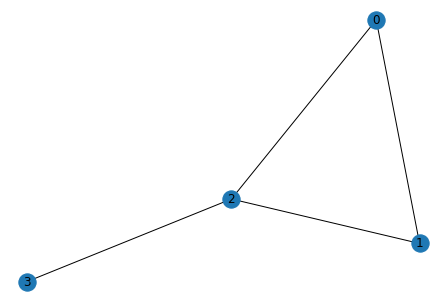

In [6]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [7]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print('Cost Hamiltonian:', cost_h)
print('Mixer Hamiltonian:', mixer_h)

Cost Hamiltonian:   (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer Hamiltonian:   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [8]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [13]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])


In [14]:
dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [15]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [16]:
for i in range(steps):
    params = optimizer.step(cost_function, params)
    
print('Opitmal Params')
print(params)

Opitmal Params
[[0.59806352 0.94198485]
 [0.52797281 0.85552845]]


In [17]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

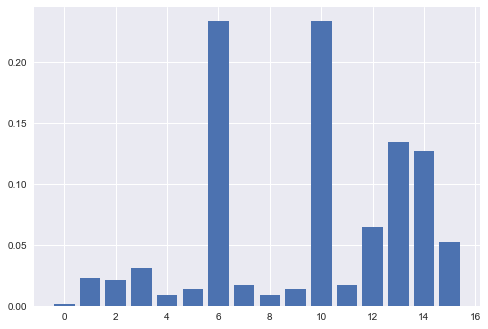

In [18]:
plt.style.use('seaborn')
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [20]:
# customizing qaoa to favour the state |1010>.

reward_h = qaoa.edge_driver(nx.Graph([(0, 2)]),['11'])

In [21]:
new_cost_h = cost_h + 2 * reward_h

In [22]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)
    
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])
    
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(new_cost_h)

params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad = True)

for i in range(steps):
    params = optimizer.step(cost_function, params)
    
print('Optimal Params')
print(params)

Optimal Params
[[0.45959941 0.96095271]
 [0.27029962 0.78042396]]


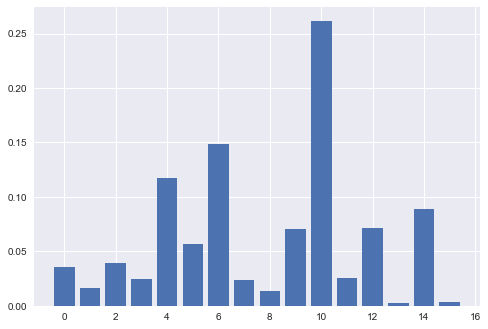

In [23]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

plt.style.use('seaborn')
plt.bar(range(2 ** len(wires)), probs)
plt.show()